<a href="https://colab.research.google.com/github/btalbr01/MLA_BTA/blob/main/MLA2_BTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning Assignment 2 <br>
Ben Albright<br>
CS430-ON<br>
Machine Learning in the Cloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, auc, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Steel_industry_data.csv')

In [5]:
df.rename({'Usage_kWh':'usage_kwh','Lagging_Current_Reactive.Power_kVarh':'lag_react_pwr_kvarh',
           'Leading_Current_Reactive_Power_kVarh':'lead_react_pwr_kvarh','Lagging_Current_Power_Factor':'lag_current_pwr',
           'Leading_Current_Power_Factor':'lead_current_pwr','NSM':'nsm','WeekStatus':'week_status', 'Day_of_week':'day_of_week',
           'Load_Type':'load_type'}, axis=1, inplace=True)

In [6]:
df.columns


Index(['date', 'usage_kwh', 'lag_react_pwr_kvarh', 'lead_react_pwr_kvarh',
       'CO2(tCO2)', 'lag_current_pwr', 'lead_current_pwr', 'nsm',
       'week_status', 'day_of_week', 'load_type'],
      dtype='object')

In [7]:
df.describe()

,usage_kwh,lag_react_pwr_kvarh,lead_react_pwr_kvarh,CO2(tCO2),lag_current_pwr,lead_current_pwr,nsm
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [8]:
df.head()

,date,usage_kwh,lag_react_pwr_kvarh,lead_react_pwr_kvarh,CO2(tCO2),lag_current_pwr,lead_current_pwr,nsm,week_status,day_of_week,load_type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [9]:
load_types = df['load_type'].value_counts()
load_types_df = pd.DataFrame(load_types)
load_types_df.reset_index(inplace=True)
load_types_df.columns = ['load_type', 'count']


In [10]:
load_types_df

,load_type,count
0,Light_Load,18072
1,Medium_Load,9696
2,Maximum_Load,7272


Text(0, 0.5, 'count')

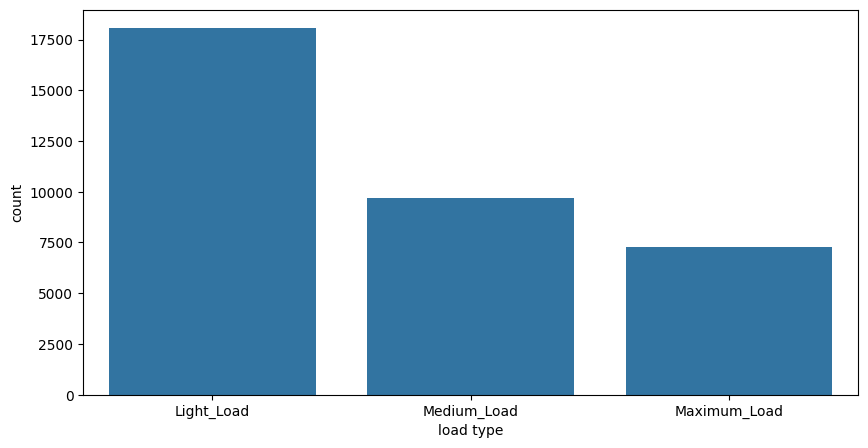

In [11]:
plt.figure(figsize=(10,5))
sns.barplot(x="load_type", y="count", data = load_types_df)
plt.xlabel('load type')
plt.ylabel('count')


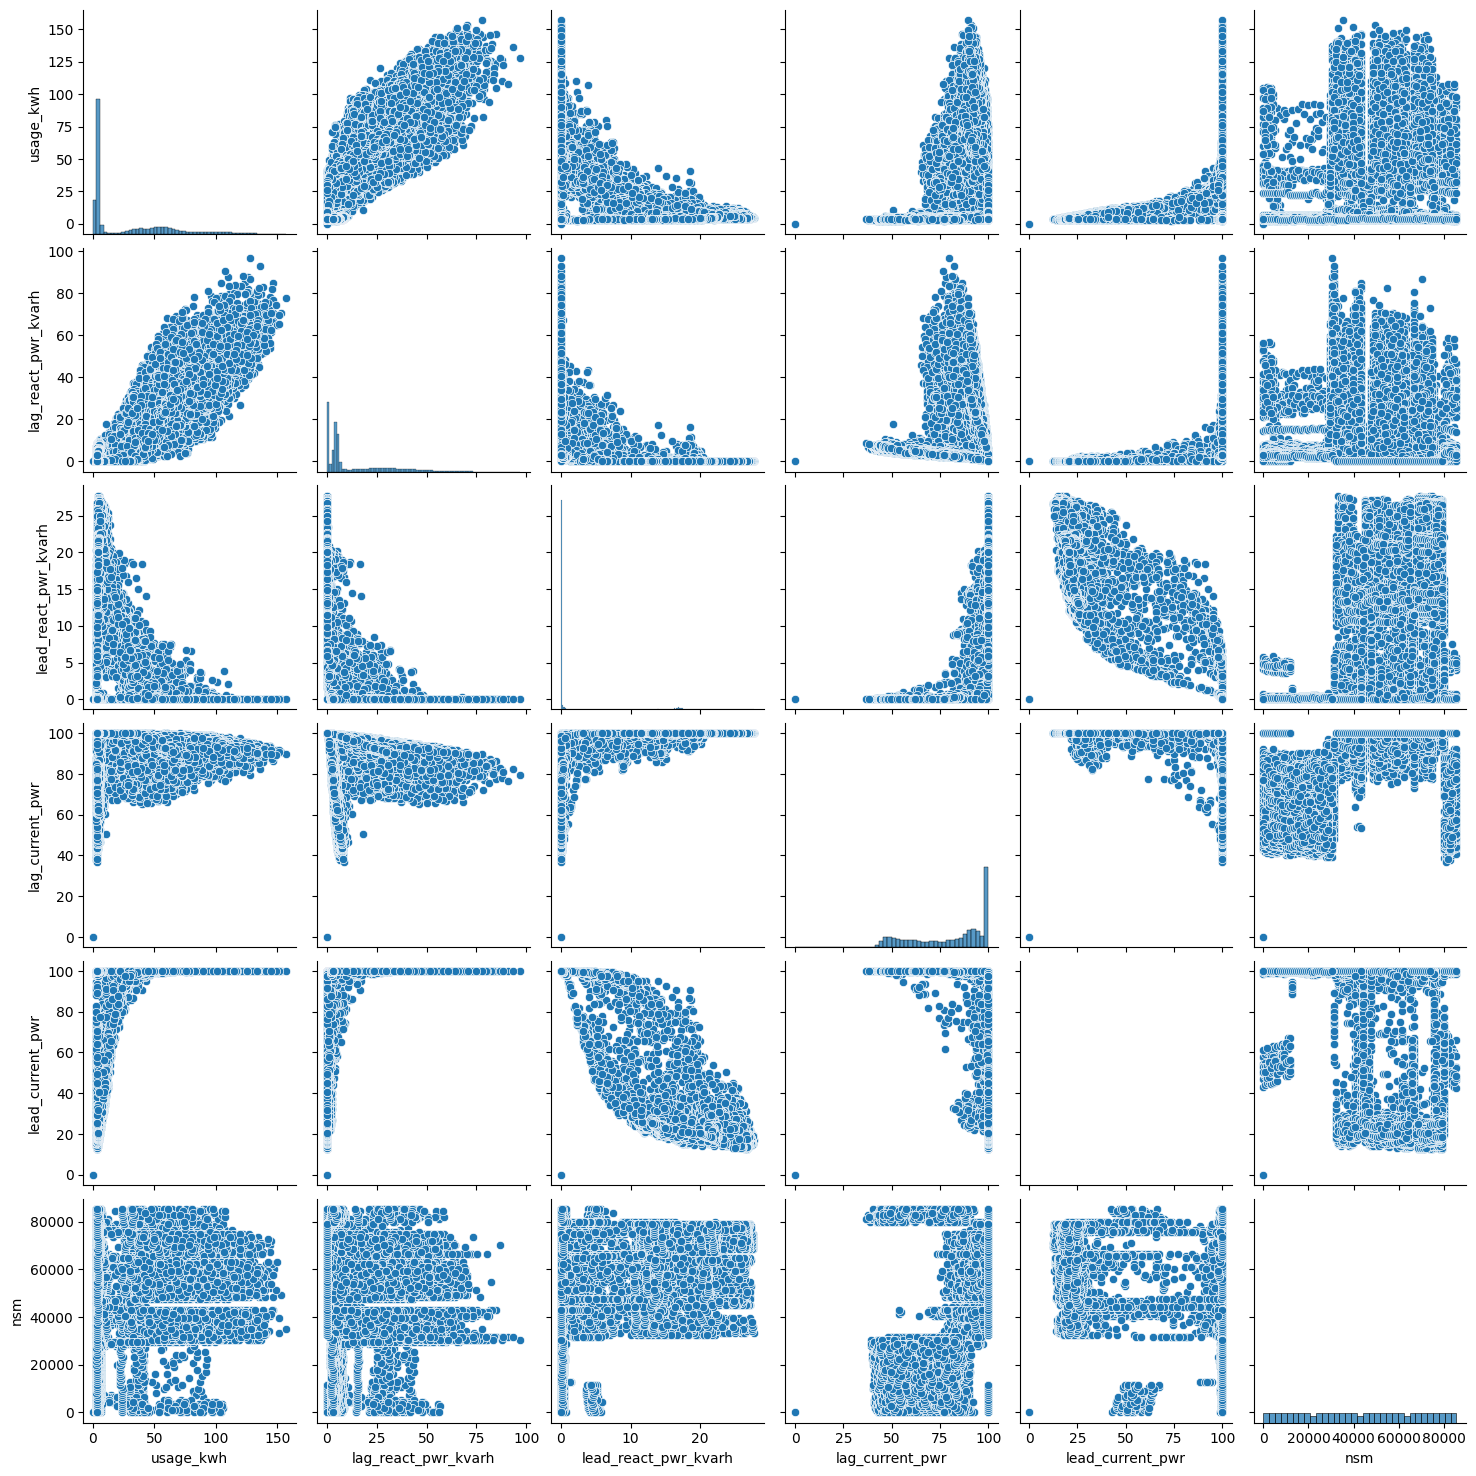

In [12]:
sns.pairplot(df[['usage_kwh', 'lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'lag_current_pwr', 'lead_current_pwr', 'nsm', 'week_status', 'day_of_week']])

It looks like usage_kwh, lag_react_pwr_kvarh and lead_react_pwr_kvarh all have similar patters when compared to nsm.
It seems like the graphs comparing usage_kwh and lag_react_pwr_kvarh to lead_current_pwr are almost identical.

In [13]:
X = df[['lag_react_pwr_kvarh', 'lead_react_pwr_kvarh',
       'CO2(tCO2)', 'lag_current_pwr', 'lead_current_pwr', 'nsm',
       'week_status', 'day_of_week', 'load_type']]

In [14]:
y = df[['usage_kwh']]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [16]:
cat_attribs = ['week_status', 'day_of_week', 'load_type']
num_attribs = ['lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'CO2(tCO2)', 'lag_current_pwr', 'lead_current_pwr', 'nsm']

In [17]:
#num_attribs = X_train.select_dtypes(include=['int64', 'float64']).columns
#cat_attribs = X_train.select_dtypes(include=['object']).columns

col_transform = ColumnTransformer(transformers=
   [('cat',OneHotEncoder(), cat_attribs),
   ('num',MinMaxScaler(), num_attribs)])

In [18]:
pipeline = Pipeline([
    ('trans', col_transform),
    ('lr', LinearRegression())
])

In [19]:
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['week_status', 'day_of_week',
                                                   'load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('lr', LinearRegression())])

In [20]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['week_status', 'day_of_week',
                                                   'load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('lr', LinearRegression())])

In [21]:
y_pred = pipeline.predict(X_test)

In [22]:
print(mean_squared_error(y_train, pipeline.predict(X_train))**(0.5))
print(mean_squared_error(y_test, pipeline.predict(X_test))**(0.5))

4.786034649250072
4.223724809997724


The train and test sets look like they are getting almost the same results. This makes it seem like the model is consistent in both datasets.

In [23]:
y_pred = pipeline.predict(X_test)
rsv = r2_score(y_test, y_pred)

print(rsv)

0.9843058848433492


It looks like the value is about 98.43%, which means that much variance is predictable in the dependant variable from the independent variable.

In [24]:
pipeline.named_steps['lr'].intercept_

array([-8.3186377e+13])

In [25]:
pipeline.named_steps['lr'].coef_

array([[ 1.13693656e+13,  6.05624081e+12,  7.12008396e+12,
         7.12008396e+12,  1.24332087e+13,  1.24332087e+13,
         7.12008396e+12,  7.12008396e+12,  7.12008396e+12,
         6.46969274e+13,  6.46969274e+13,  6.46969274e+13,
         3.17302735e+01,  1.97556169e+00,  1.15056434e+02,
         1.21928787e+01,  6.06586058e+00, -2.29621887e-01]])

I think this is a suitable model. The RSME values for both train and test are fairly close, and the R-squared value of the model is very high.

In [26]:
df['week_status']=df['week_status'].replace({'Weekday':1, 'Weekend':0})

In [27]:
X = df[['usage_kwh', 'lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'CO2(tCO2)', 'lag_current_pwr', 'lead_current_pwr', 'nsm', 'load_type']]

In [28]:
y = df[['week_status']]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
cat_attribs = ['load_type']
num_attribs = ['lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'CO2(tCO2)', 'lag_current_pwr', 'lead_current_pwr', 'nsm']

In [31]:
col_transform = ColumnTransformer(transformers=
   [('cat',OneHotEncoder(), cat_attribs),
   ('num',MinMaxScaler(), num_attribs)])

In [32]:
pipe = Pipeline([
    ('prep', col_transform),
    ('mlr', LogisticRegression(max_iter=1000))
])

In [33]:
pipe.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('mlr', LogisticRegression(max_iter=1000))])

In [34]:
y_pred = pipe.predict(X_test)

In [35]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

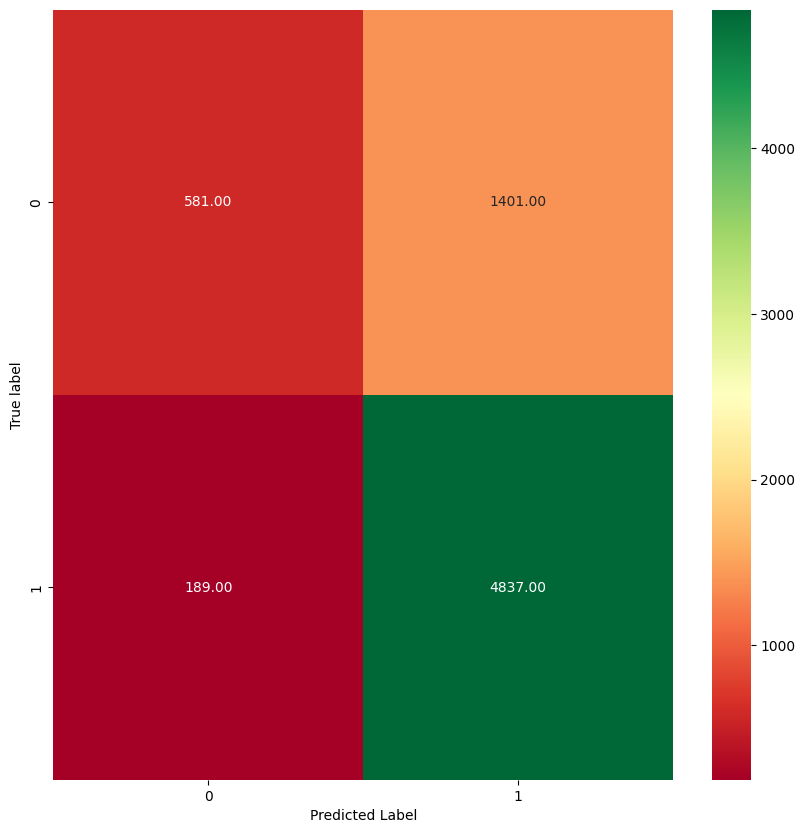

In [36]:
plot_cm(y_test, y_pred)

In [37]:
precision_score(y_test, y_pred)



0.7754087848669445

In [38]:
recall_score(y_test, y_pred)

0.9623955431754875

In [39]:
f1_score(y_test, y_pred)

0.8588423295454546

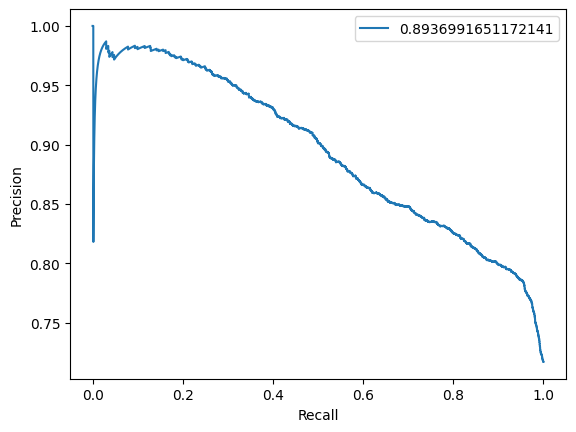

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, pipe.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)

plt.figure()

plt.plot(recall, precision, label = pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

I used the because the difference between the precision and recall are so significant. The high recall score implies that the dataset might be imbalanced,and it also provides a better view of false positives.

This model seems decent to good for predicting week_status. The recall score is over 96%. The precision isn't as good at only 77.54%, but that is still better than one might get just by guessing randomly. I'm sure there is room for refinement.